In [1]:
import tensorflow as tf
import torch
import torch.nn as nn
import torch.nn.functional as F
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from keras.datasets import mnist, fashion_mnist
from keras.models import Sequential
from keras.layers import Dense
from keras.models import Model
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

### *MNIST Dataset*

In [ ]:
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
labels = [0,1,2,3,4,5,6,7,8,9]
# Flatten the image data
train_images = train_images.reshape((60000, 28 * 28)).astype('float32') / 255
test_images = test_images.reshape((10000, 28 * 28)).astype('float32') / 255

### *Classification using Random Forest*

In [ ]:
# Train a random forest classifier
rf_classifier = RandomForestClassifier(n_estimators=50, bootstrap=True, max_features='sqrt',random_state=0)
rf_classifier.fit(train_images, train_labels)

RandomForestClassifier(n_estimators=50, random_state=0)

##### *Predictions on Training data*

In [ ]:
# On the Training data
pred_train_labels = rf_classifier.predict(train_images)
print('Random Forest Classifier on Training Data')
accuracy_rf = accuracy_score(train_labels,pred_train_labels)
print(f'Accuracy of Random Forest Classifier:- {accuracy_rf:.3f}')
print("-"*50)

f1 = f1_score(train_labels, pred_train_labels, average='weighted')  # or 'macro', 'micro', 'samples', 'weighted'
print(f"F1 Score of Random Forest classifier:- {f1:.3f}")
print("-"*50)

precision_per_class = precision_score(train_labels, pred_train_labels, average=None)
recall_per_class = recall_score(train_labels, pred_train_labels, average=None)
df_precision_recall = pd.DataFrame({'label':labels, 'Precision':precision_per_class, 'Recall':recall_per_class})
df_precision_recall.set_index('label', inplace=True)
print("Precision and Recall for each class using Random Forest Classifier:-")
print()
print(df_precision_recall)

Random Forest Classifier on Training Data
Accuracy of Random Forest Classifier:- 1.000
--------------------------------------------------
F1 Score of Random Forest classifier:- 1.000
--------------------------------------------------
Precision and Recall for each class using Random Forest Classifier:-

       Precision  Recall
label                   
0            1.0     1.0
1            1.0     1.0
2            1.0     1.0
3            1.0     1.0
4            1.0     1.0
5            1.0     1.0
6            1.0     1.0
7            1.0     1.0
8            1.0     1.0
9            1.0     1.0


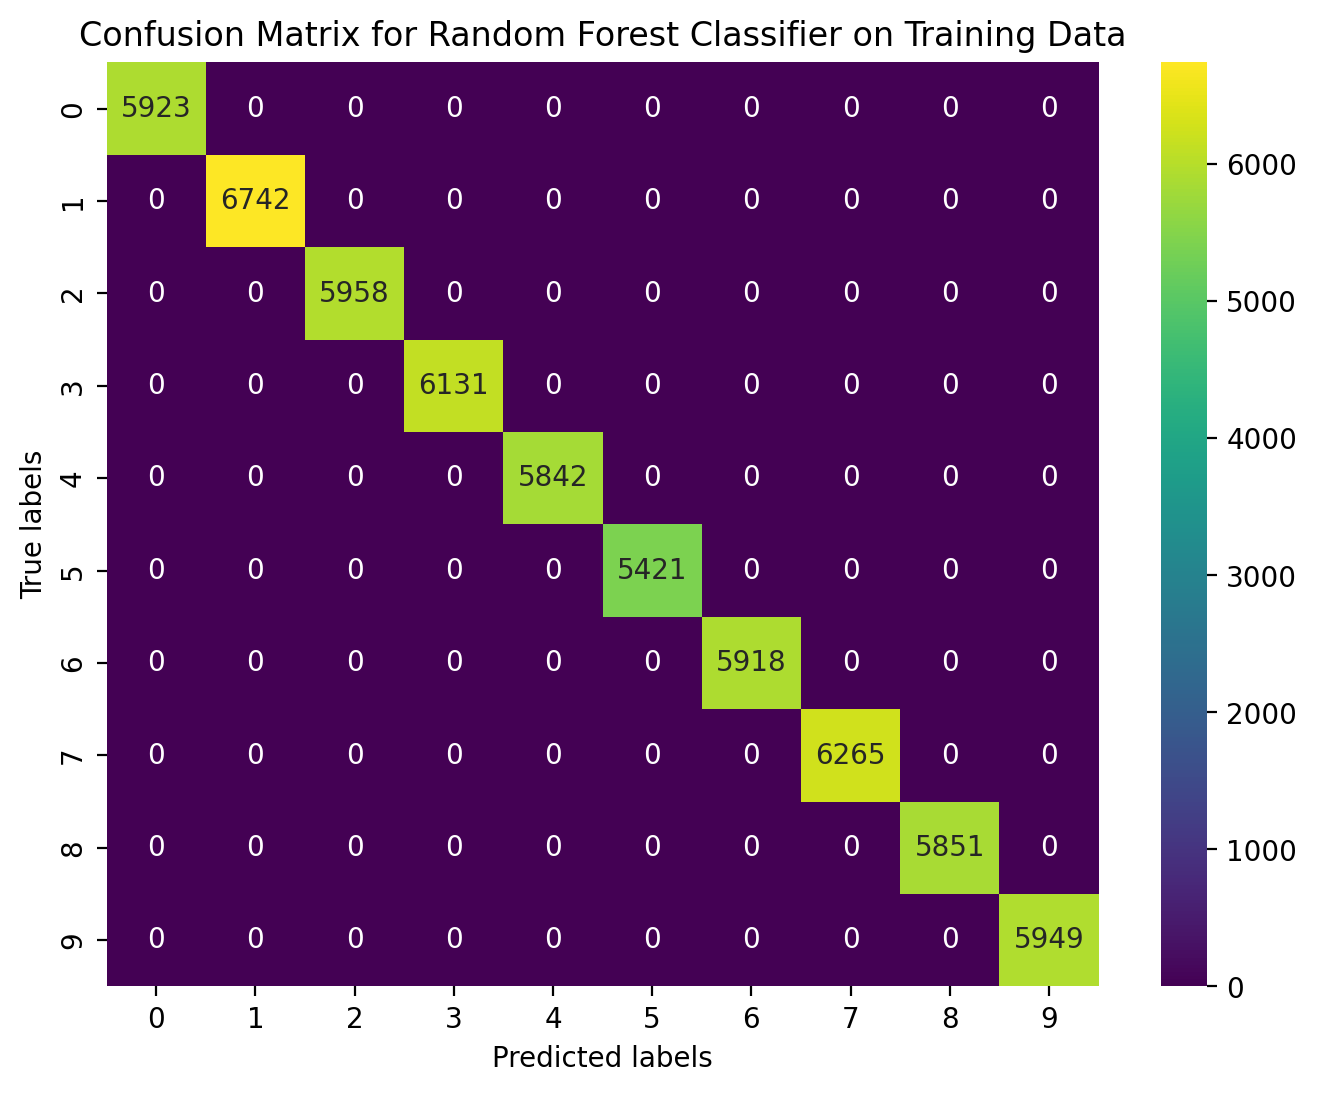

In [ ]:
cm = confusion_matrix(train_labels, pred_train_labels)

# Step 2: Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='viridis', fmt='g', cbar=True)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for Random Forest Classifier on Training Data')
plt.show()

##### *Predictions on Test data*

In [ ]:
# Test the random forest classifier
img_pred = rf_classifier.predict(test_images)

print('Random Forest Classifier on Test Data')
accuracy_rf = accuracy_score(test_labels,img_pred)
print(f'Accuracy of Random Forest Classifier:- {accuracy_rf:.3f}')
print("-"*50)

f1 = f1_score(test_labels, img_pred, average='weighted')  # or 'macro', 'micro', 'samples', 'weighted'
print(f"F1 Score of Random Forest classifier:- {f1:.3f}")
print("-"*50)

precision_per_class = precision_score(test_labels, img_pred, average=None)
recall_per_class = recall_score(test_labels, img_pred, average=None)
df_precision_recall = pd.DataFrame({'label':labels, 'Precision':precision_per_class, 'Recall':recall_per_class})
df_precision_recall.set_index('label', inplace=True)
print("Precision and Recall for each class using Random Forest Classifier:-")
print()
print(df_precision_recall)

Random Forest Classifier on Test Data
Accuracy of Random Forest Classifier:- 0.967
--------------------------------------------------
F1 Score of Random Forest classifier:- 0.967
--------------------------------------------------
Precision and Recall for each class using Random Forest Classifier:-

       Precision    Recall
label                     
0       0.970942  0.988776
1       0.989390  0.985903
2       0.960539  0.967054
3       0.954724  0.960396
4       0.971370  0.967413
5       0.959732  0.961883
6       0.973001  0.978079
7       0.970501  0.960117
8       0.962539  0.949692
9       0.952144  0.946482


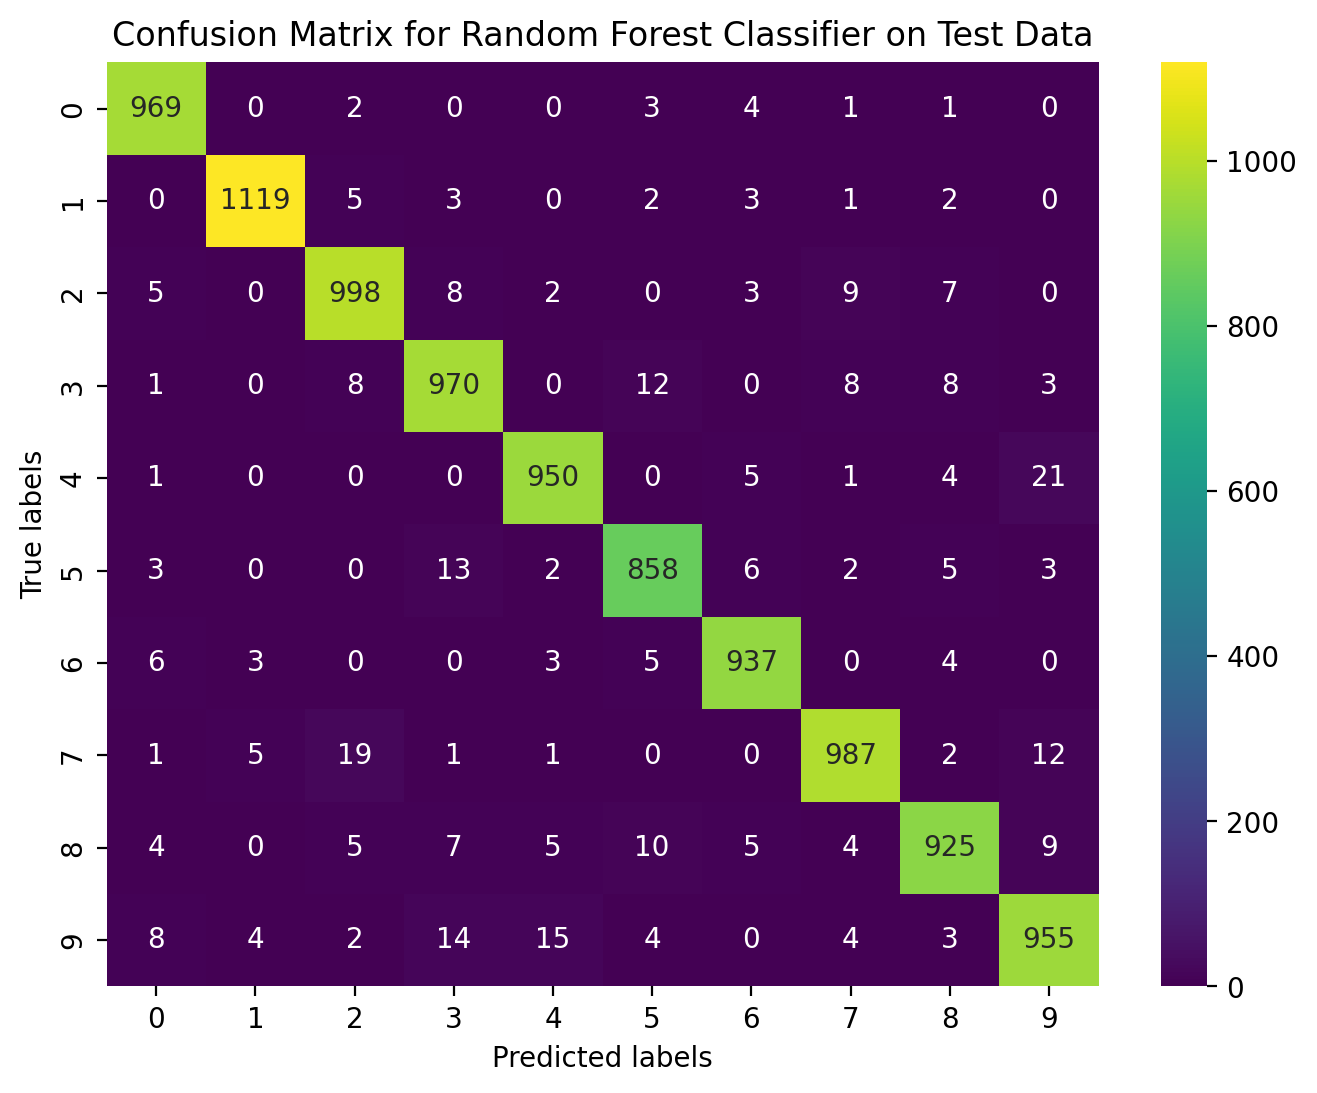

In [ ]:
cm = confusion_matrix(test_labels, img_pred)

# Step 2: Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='viridis', fmt='g', cbar=True)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for Random Forest Classifier on Test Data')
plt.show()

##### *Random Forest Classifier confuses on:- 0,3,5,7,9*

### *Classification using Logistic Regression*

In [8]:
class MultiClassLogisticRegression(nn.Module):
    """Logistic Regression model for multi-class classification

    Inputs:
        nn.Module: Base class for all neural network modules in PyTorch
        input_dim: The total number of input features
        num_classes: The total number of classes in the dataset

    Outputs:
        logits: The raw, unnormalized scores for each class
    """
    def __init__(self, input_dim, num_classes):
        super(MultiClassLogisticRegression, self).__init__()
        self.linear = nn.Linear(input_dim, num_classes)

    def forward(self, x):
        logits = self.linear(x)
        return logits

In [9]:
# Create an instance of the model
mlr = MultiClassLogisticRegression(784, 10)

In [ ]:
# Convert the training and test data to PyTorch tensors
X_tensor_train = torch.tensor(train_images, dtype=torch.float32)
y_tensor_train = torch.tensor(train_labels, dtype=torch.long)
X_tensor_test = torch.tensor(test_images, dtype=torch.float32)
y_tensor_test = torch.tensor(test_labels, dtype=torch.long)


In [ ]:
opt = torch.optim.Adam(mlr.parameters(), lr=0.01)

converged = False
prev_loss = 1e8

i = 0
while not converged:
    opt.zero_grad()
    logits = mlr(X_tensor_train)
    loss = F.cross_entropy(logits, y_tensor_train)
    loss.backward()
    opt.step()
    if i%100==0:
        print(i, loss.item())
    if np.abs(prev_loss - loss.item()) < 1e-5:
        converged = True
    prev_loss = loss.item()
    i = i + 1

0 2.3386363983154297
100 0.283933162689209
200 0.2554119825363159
300 0.24263440072536469
400 0.23502102494239807
500 0.22982895374298096
600 0.2259974628686905
700 0.2230190932750702
800 0.22061693668365479
900 0.2186271995306015
1000 0.2169462889432907
1100 0.2155046910047531
1200 0.21425335109233856
1300 0.21315611898899078


##### *Predictions on Training data*

In [ ]:
pred = F.softmax(mlr(X_tensor_train), dim=-1).detach().numpy()

# Find prediction
y_pred_train = pred.argmax(axis=-1)

accuracy_lr = (y_pred_train == train_labels).mean()
print('Logistic Regression on Training Data')
print(f'Accuracy of Logistic Regression:- {accuracy_lr:.3f}')
print("-"*50)

f1 = f1_score(train_labels, y_pred_train, average='weighted')
print(f"F1 Score of Logistic Regression:- {f1:.3f}")

precision_per_class = precision_score(train_labels, y_pred_train, average=None)
recall_per_class = recall_score(train_labels, y_pred_train, average=None)
df_precision_recall = pd.DataFrame({'label':labels, 'Precision':precision_per_class, 'Recall':recall_per_class})
df_precision_recall.set_index('label', inplace=True)
print("Precision and Recall for each class using Logistic Regression:-")
print()
print(df_precision_recall)

Logistic Regression on Training Data
Accuracy of Logistic Regression:- 0.941
--------------------------------------------------
F1 Score of Logistic Regression:- 0.941
Precision and Recall for each class using Logistic Regression:-

       Precision    Recall
label                     
0       0.972801  0.978220
1       0.963753  0.978048
2       0.939471  0.924807
3       0.924584  0.915838
4       0.943744  0.947621
5       0.914969  0.911087
6       0.959966  0.968401
7       0.952312  0.949880
8       0.912139  0.906683
9       0.921375  0.923853


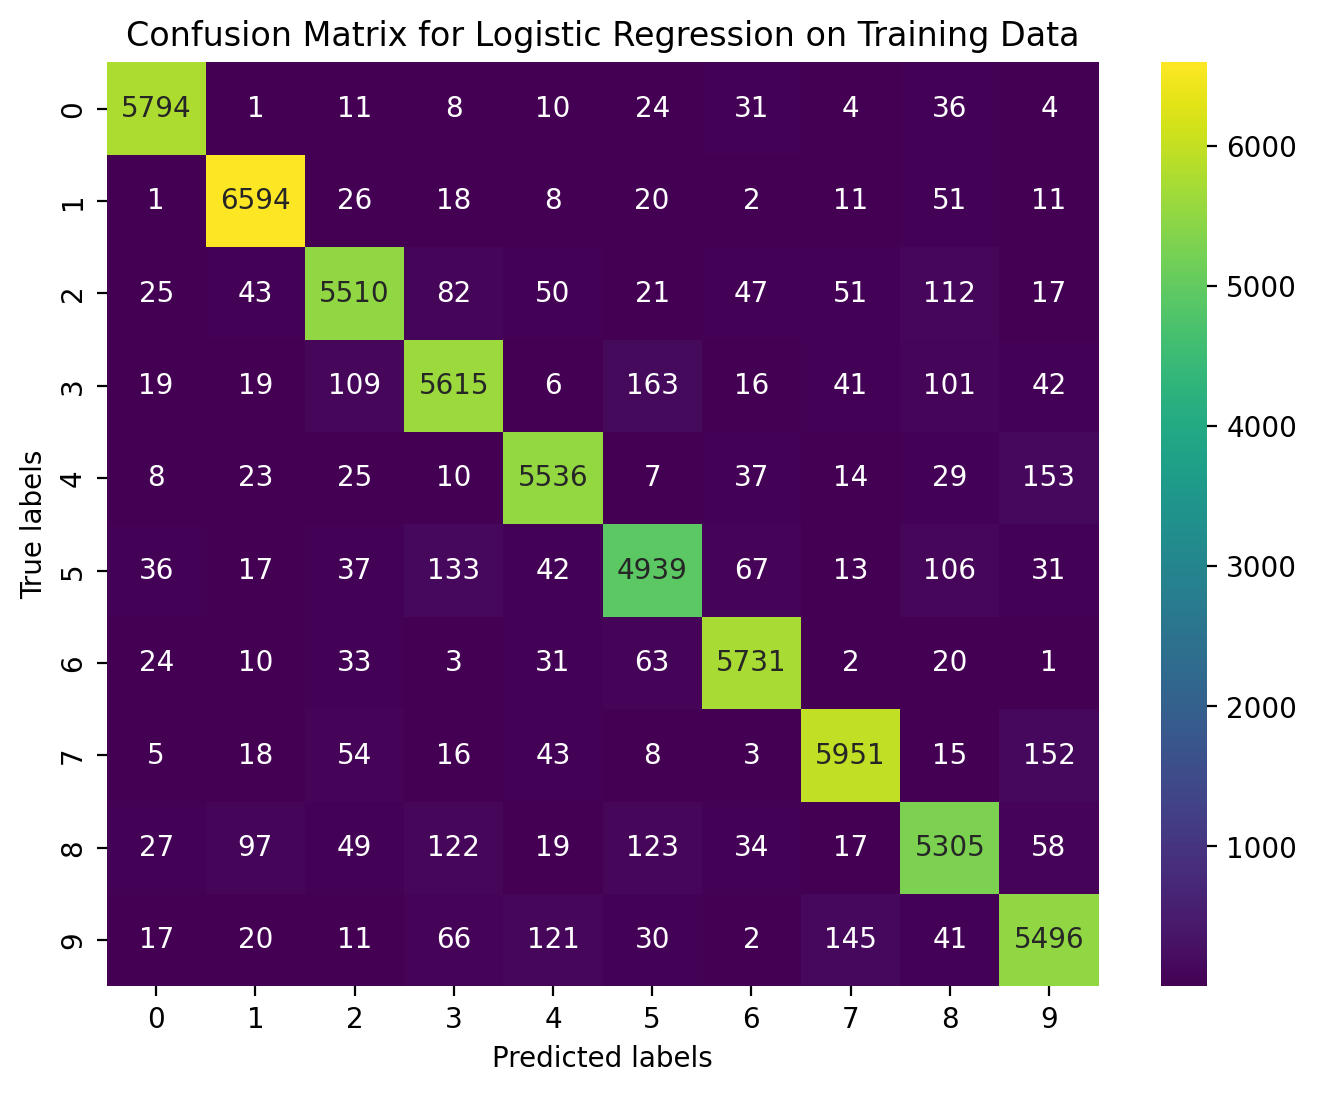

In [ ]:
cm = confusion_matrix(train_labels, y_pred_train)

# Step 2: Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='viridis', fmt='g', cbar=True)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for Logistic Regression on Training Data')
plt.show()

##### *Predictions on Test data*

In [ ]:
pred = F.softmax(mlr(X_tensor_test), dim=-1).detach().numpy()

# Find prediction
y_pred_test = pred.argmax(axis=-1)

accuracy_lr = (y_pred_test == test_labels).mean()
print('Logistic Regression on Test Data')
print(f'Accuracy of Logistic Regression:- {accuracy_lr:.3f}')
print("-"*50)

f1 = f1_score(test_labels, y_pred_test, average='weighted')
print(f"F1 Score of Logistic Regression:- {f1:.3f}")

precision_per_class = precision_score(test_labels, y_pred_test, average=None)
recall_per_class = recall_score(test_labels, y_pred_test, average=None)
df_precision_recall = pd.DataFrame({'label':labels, 'Precision':precision_per_class, 'Recall':recall_per_class})
df_precision_recall.set_index('label', inplace=True)
print("Precision and Recall for each class using Logistic Regression:-")
print()
print(df_precision_recall)

Logistic Regression on Test Data
Accuracy of Logistic Regression:- 0.927
--------------------------------------------------
F1 Score of Logistic Regression:- 0.927
Precision and Recall for each class using Logistic Regression:-

       Precision    Recall
label                     
0       0.953954  0.972449
1       0.962738  0.978855
2       0.932460  0.896318
3       0.906863  0.915842
4       0.939673  0.935845
5       0.902098  0.867713
6       0.943299  0.955115
7       0.923524  0.928016
8       0.879188  0.889117
9       0.915925  0.917740


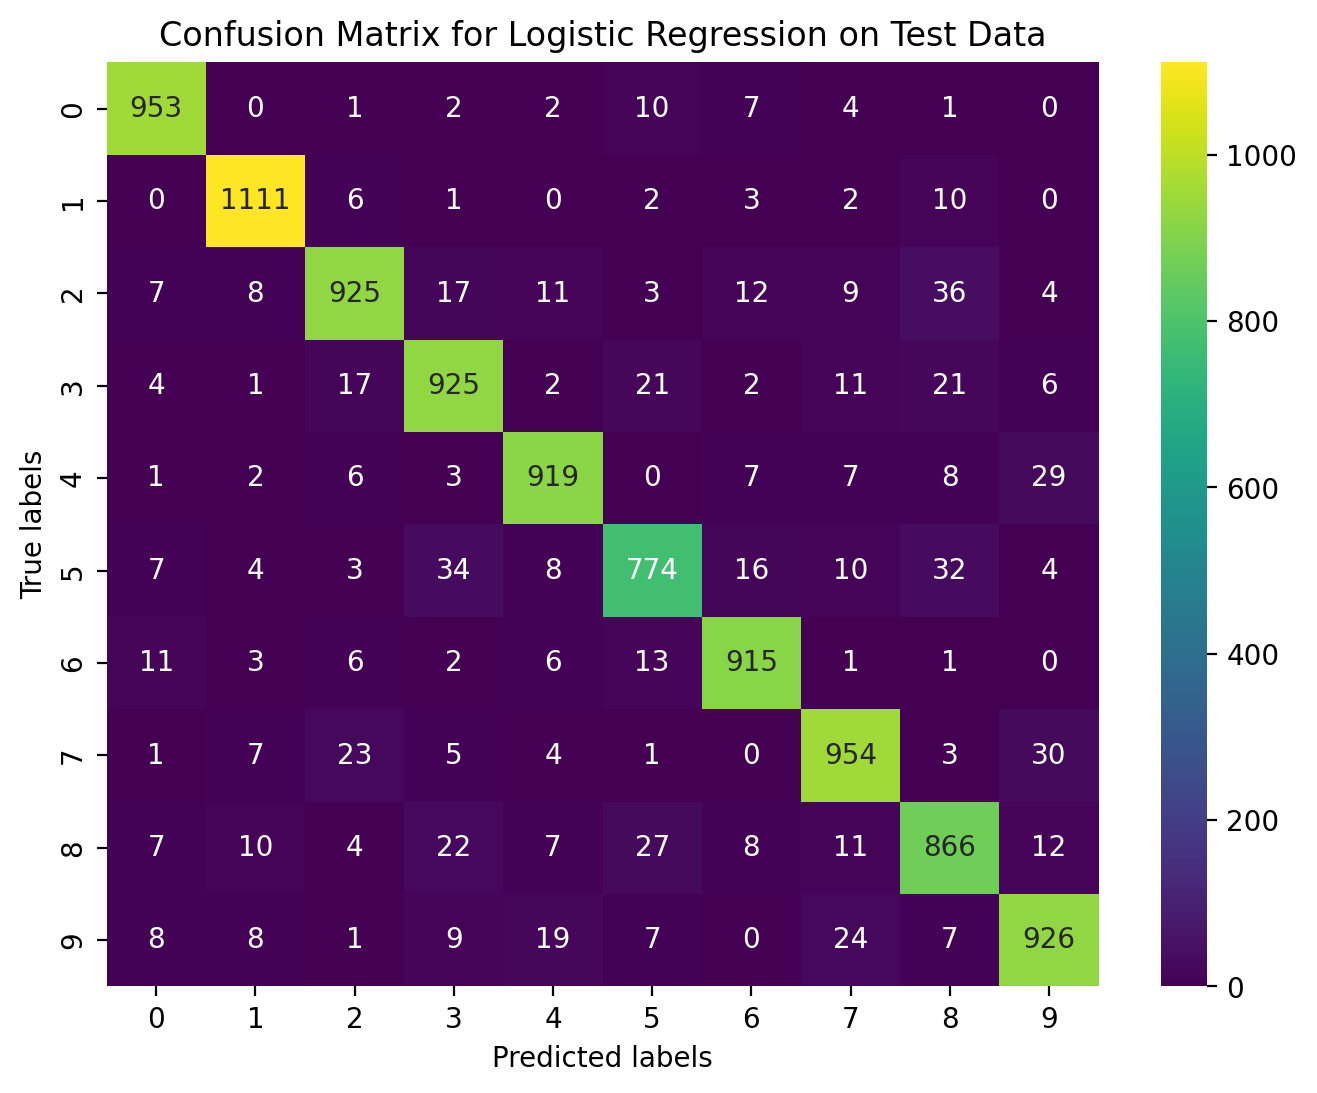

In [ ]:
cm = confusion_matrix(test_labels,y_pred_test)

# Step 2: Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='viridis', fmt='g', cbar=True)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for Logistic Regression on Test Data')
plt.show()

*Logistic Regression confuses on the digits:- 8,5,3,2,9*

## *Multi Layer Perceptron (MLP)*

### *MLP Model*

In [6]:
def create_mlp(input_dim, output_dim):
    """Create a simple multi-layer perceptron model

    Args:
        input_dim (int): The number of input features
        output_dim (int): The number of output classes

    Returns:
        model: A compiled Keras model
        history: The training history of the model
    """
    model = Sequential()
    model.add(Dense(30, input_dim=input_dim, activation='relu'))
    model.add(Dense(20, activation='relu'))
    model.add(Dense(output_dim, activation='softmax'))
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

def train_model(model, X_train, y_train):
    history = model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=1)
    return history

### *Function to plot embeddings*

In [7]:
def plot_tsne(embeddings, labels, title):
    """Plot a t-SNE visualization of the embeddings

    Args:
        embeddings : The 2D embeddings of the data
        labels : The labels of the data
        title : The title of the plot
    """
    tsne = TSNE(n_components=2, random_state=42)
    embeddings_tsne = tsne.fit_transform(embeddings)

    plt.figure(figsize=(10, 8))
    for i in range(10):
        plt.scatter(embeddings_tsne[labels == i, 0], embeddings_tsne[labels == i, 1], label=str(i))
    plt.title(title)
    plt.legend()
    plt.show()

##### *MNIST and FMNIST dataset*

In [9]:
# Load MNIST dataset
(x_train_mnist,y_train_mnist), (x_test_mnist, y_test_mnist) = mnist.load_data()

# Flatten the image data
x_train_mnist = x_train_mnist.reshape((60000, 28 * 28)).astype('float32') / 255
x_test_mnist = x_test_mnist.reshape((10000, 28 * 28)).astype('float32') / 255

# Load Fashion-MNIST dataset
fashion_mnist = tf.keras.datasets.fashion_mnist
(x_train_fmnist, y_train_fmnist), (x_test_fmnist, y_test_fmnist) = fashion_mnist.load_data()
x_train_fmnist = x_train_fmnist.reshape((60000, 28 * 28)).astype('float32') / 255
x_test_fmnist = x_test_fmnist.reshape((10000, 28 * 28)).astype('float32') / 255
labels = [0,1,2,3,4,5,6,7,8,9]

##### *MLP Model trained on MNIST dataset*

In [56]:
# Define the MLP for MNIST
mnist_model = create_mlp(x_train_mnist.shape[1], 10)
fmnist_model = create_mlp(x_train_fmnist.shape[1], 10)

# Extract output from the layer containing 20 neurons
layer20_output_mnist = Model(inputs=mnist_model.input, outputs=mnist_model.layers[1].output)
layer20_output_mnist.compile()

layer20_output_fmnist = Model(inputs=fmnist_model.input, outputs=fmnist_model.layers[1].output)
layer20_output_fmnist.compile()


In [57]:
# Extract output from the untrained MLP
untrained_predictions_mnist = layer20_output_mnist.predict(x_test_mnist)
untrained_predictions_fmnist = layer20_output_fmnist.predict(x_test_fmnist)

313/313 [==============================] - 0s 1ms/step


In [58]:
train_model(mnist_model, x_train_mnist, y_train_mnist)

Epoch 1/10
1875/1875 [==============================] - 7s 3ms/step - loss: 0.3722 - accuracy: 0.8918
Epoch 2/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.1807 - accuracy: 0.9469
Epoch 3/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.1426 - accuracy: 0.9578
Epoch 4/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.1217 - accuracy: 0.9640
Epoch 5/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.1072 - accuracy: 0.9684
Epoch 6/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0957 - accuracy: 0.9708
Epoch 7/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0863 - accuracy: 0.9740
Epoch 8/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0801 - accuracy: 0.9763
Epoch 9/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0730 - accuracy: 0.9778
Epoch 10/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.068

In [59]:
train_model(fmnist_model, x_train_fmnist, y_train_fmnist)

Epoch 1/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.5646 - accuracy: 0.8023
Epoch 2/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.4140 - accuracy: 0.8520
Epoch 3/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.3758 - accuracy: 0.8654
Epoch 4/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.3548 - accuracy: 0.8721
Epoch 5/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.3391 - accuracy: 0.8771
Epoch 6/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.3270 - accuracy: 0.8808
Epoch 7/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.3167 - accuracy: 0.8835
Epoch 8/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.3093 - accuracy: 0.8872
Epoch 9/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2993 - accuracy: 0.8893
Epoch 10/10
1875/1875 [==============================] - 8s 5ms/step - loss: 0.293

In [60]:
# Extract output from the trained MLP
trained_predictions_mnist = layer20_output_mnist.predict(x_test_mnist)
trained_predictions_fmnist_mnist = layer20_output_mnist.predict(x_test_fmnist)
trained_predictions_fmnist = layer20_output_fmnist.predict(x_test_fmnist)

313/313 [==============================] - 0s 2ms/step


### *Embedding Layer plot of MNIST Model*

##### *Untrained MLP on MNIST dataset*

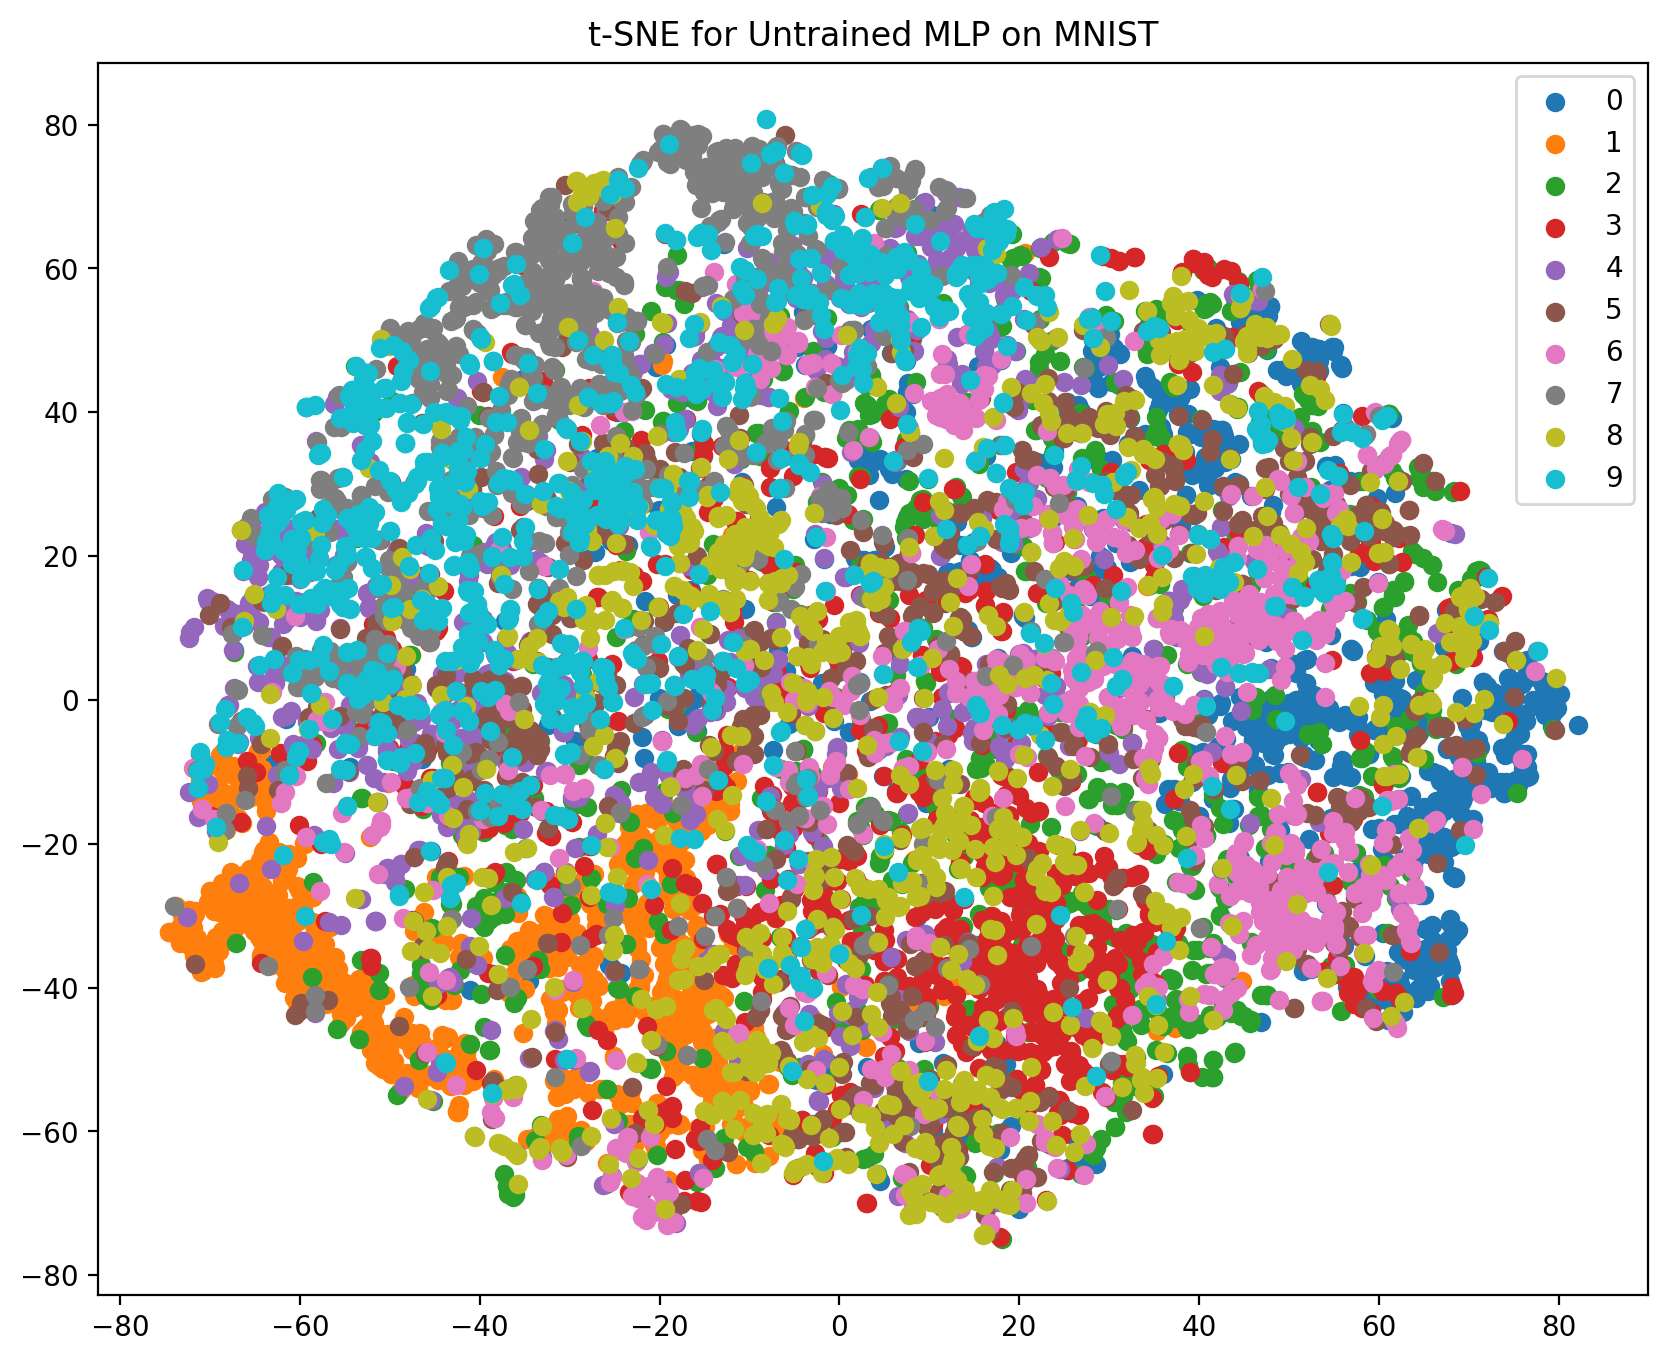

In [70]:
# Plot t-SNE for MNIST
plot_tsne(untrained_predictions_mnist, y_test_mnist, "t-SNE for Untrained MLP on MNIST")


##### *Trained MLP on MNIST dataset*

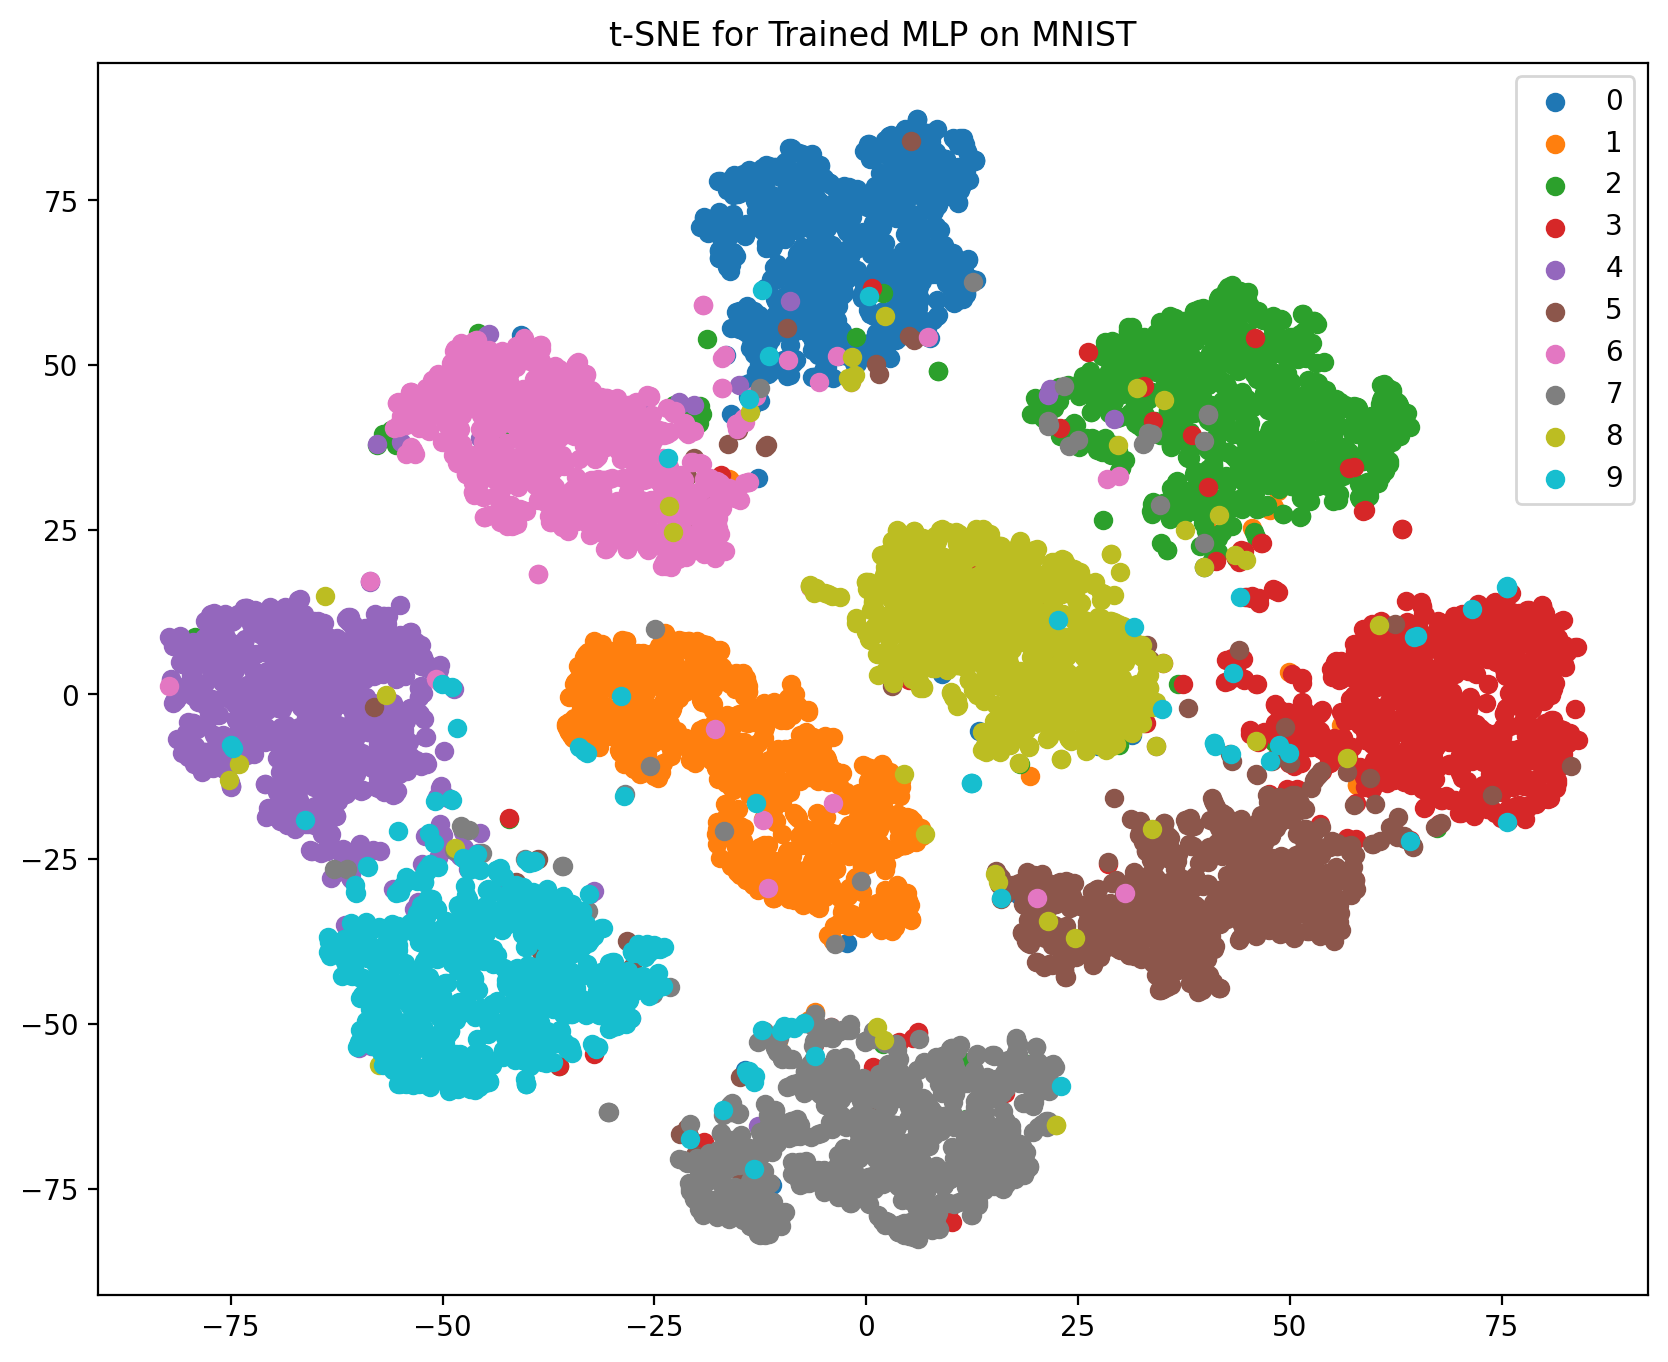

In [71]:
plot_tsne(trained_predictions_mnist, y_test_mnist, "t-SNE for Trained MLP on MNIST")

##### *Trained MLP on FMNIST dataset*

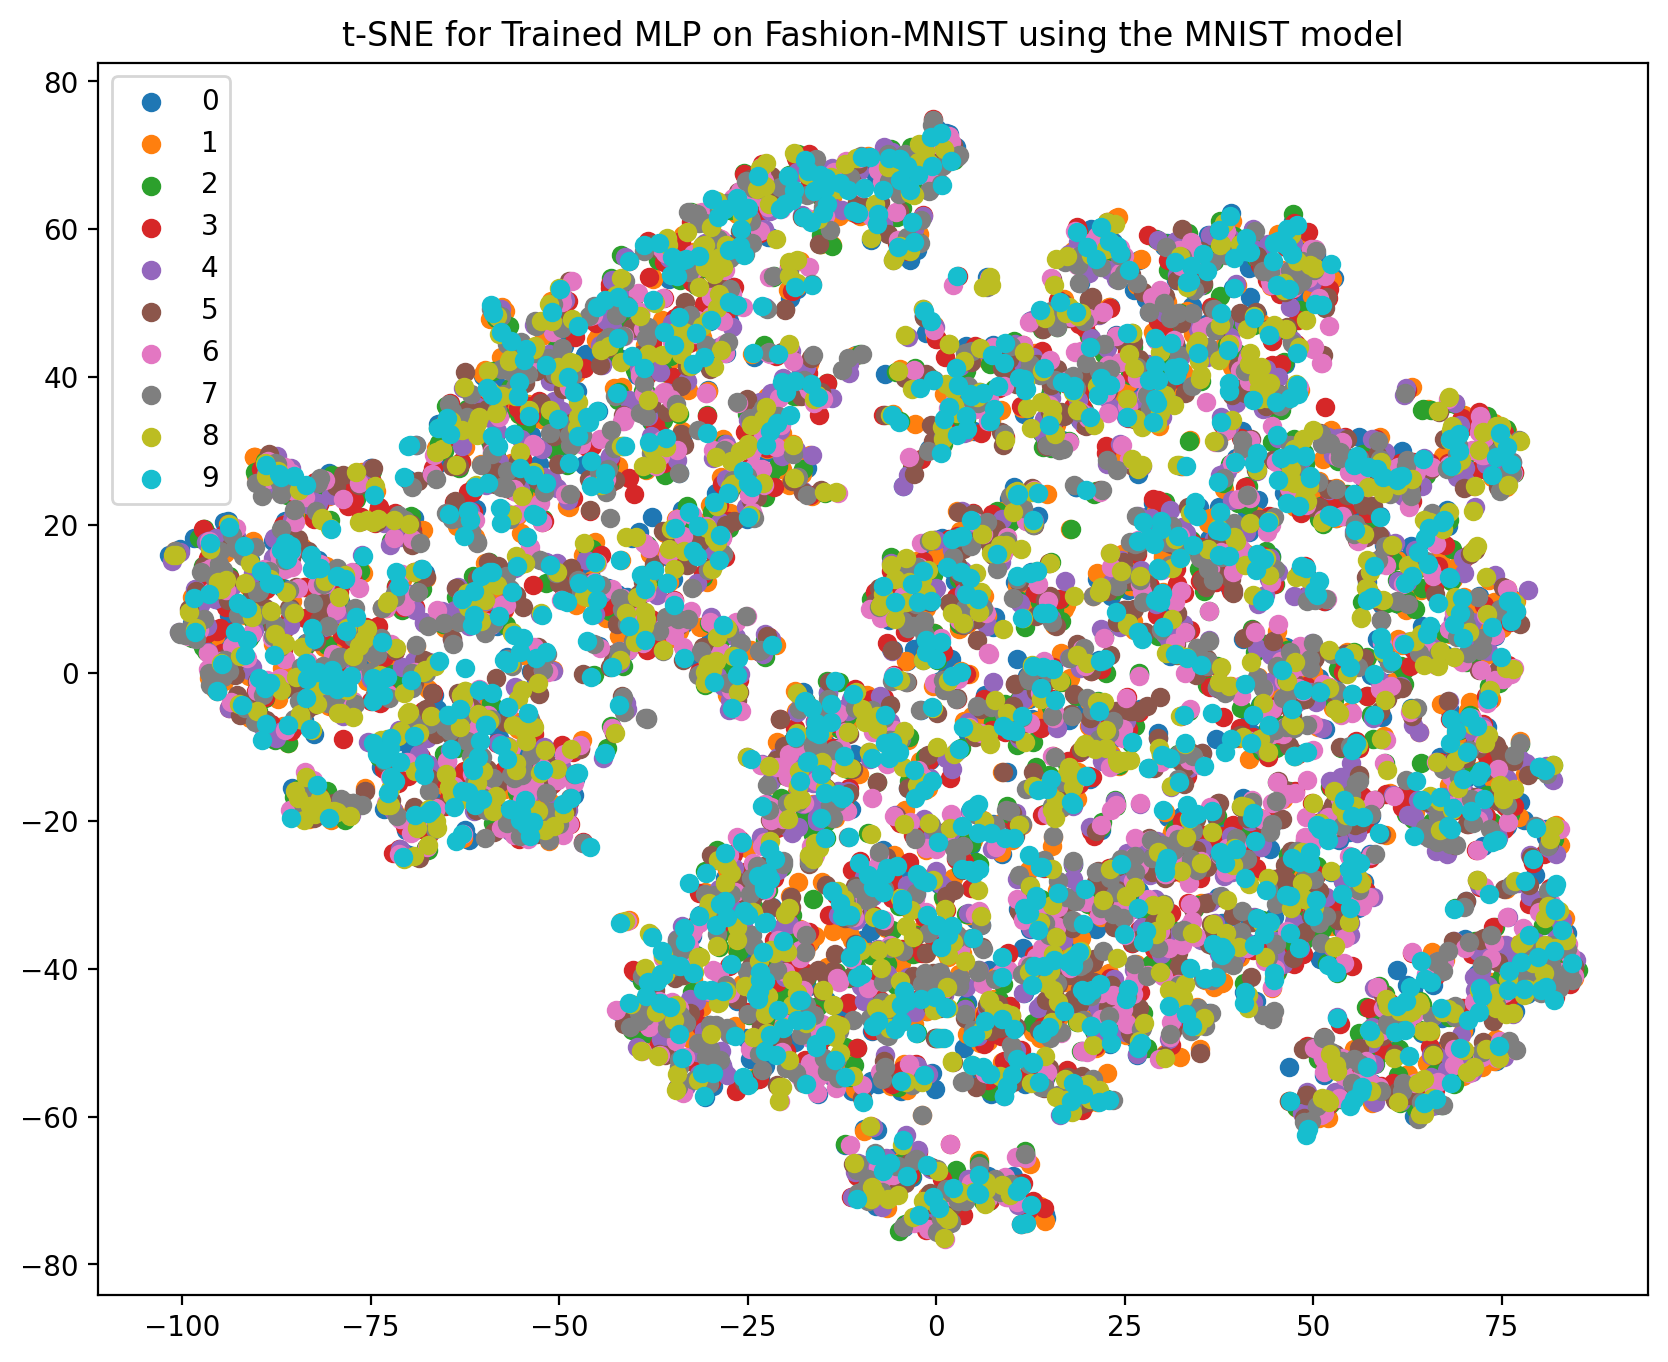

In [72]:
plot_tsne(trained_predictions_fmnist_mnist, y_test_mnist, "t-SNE for Trained MLP on Fashion-MNIST using the MNIST model")

### *Embedding Layer plot of FMNIST Model*

##### *Untrained MLP on FMNIST dataset*

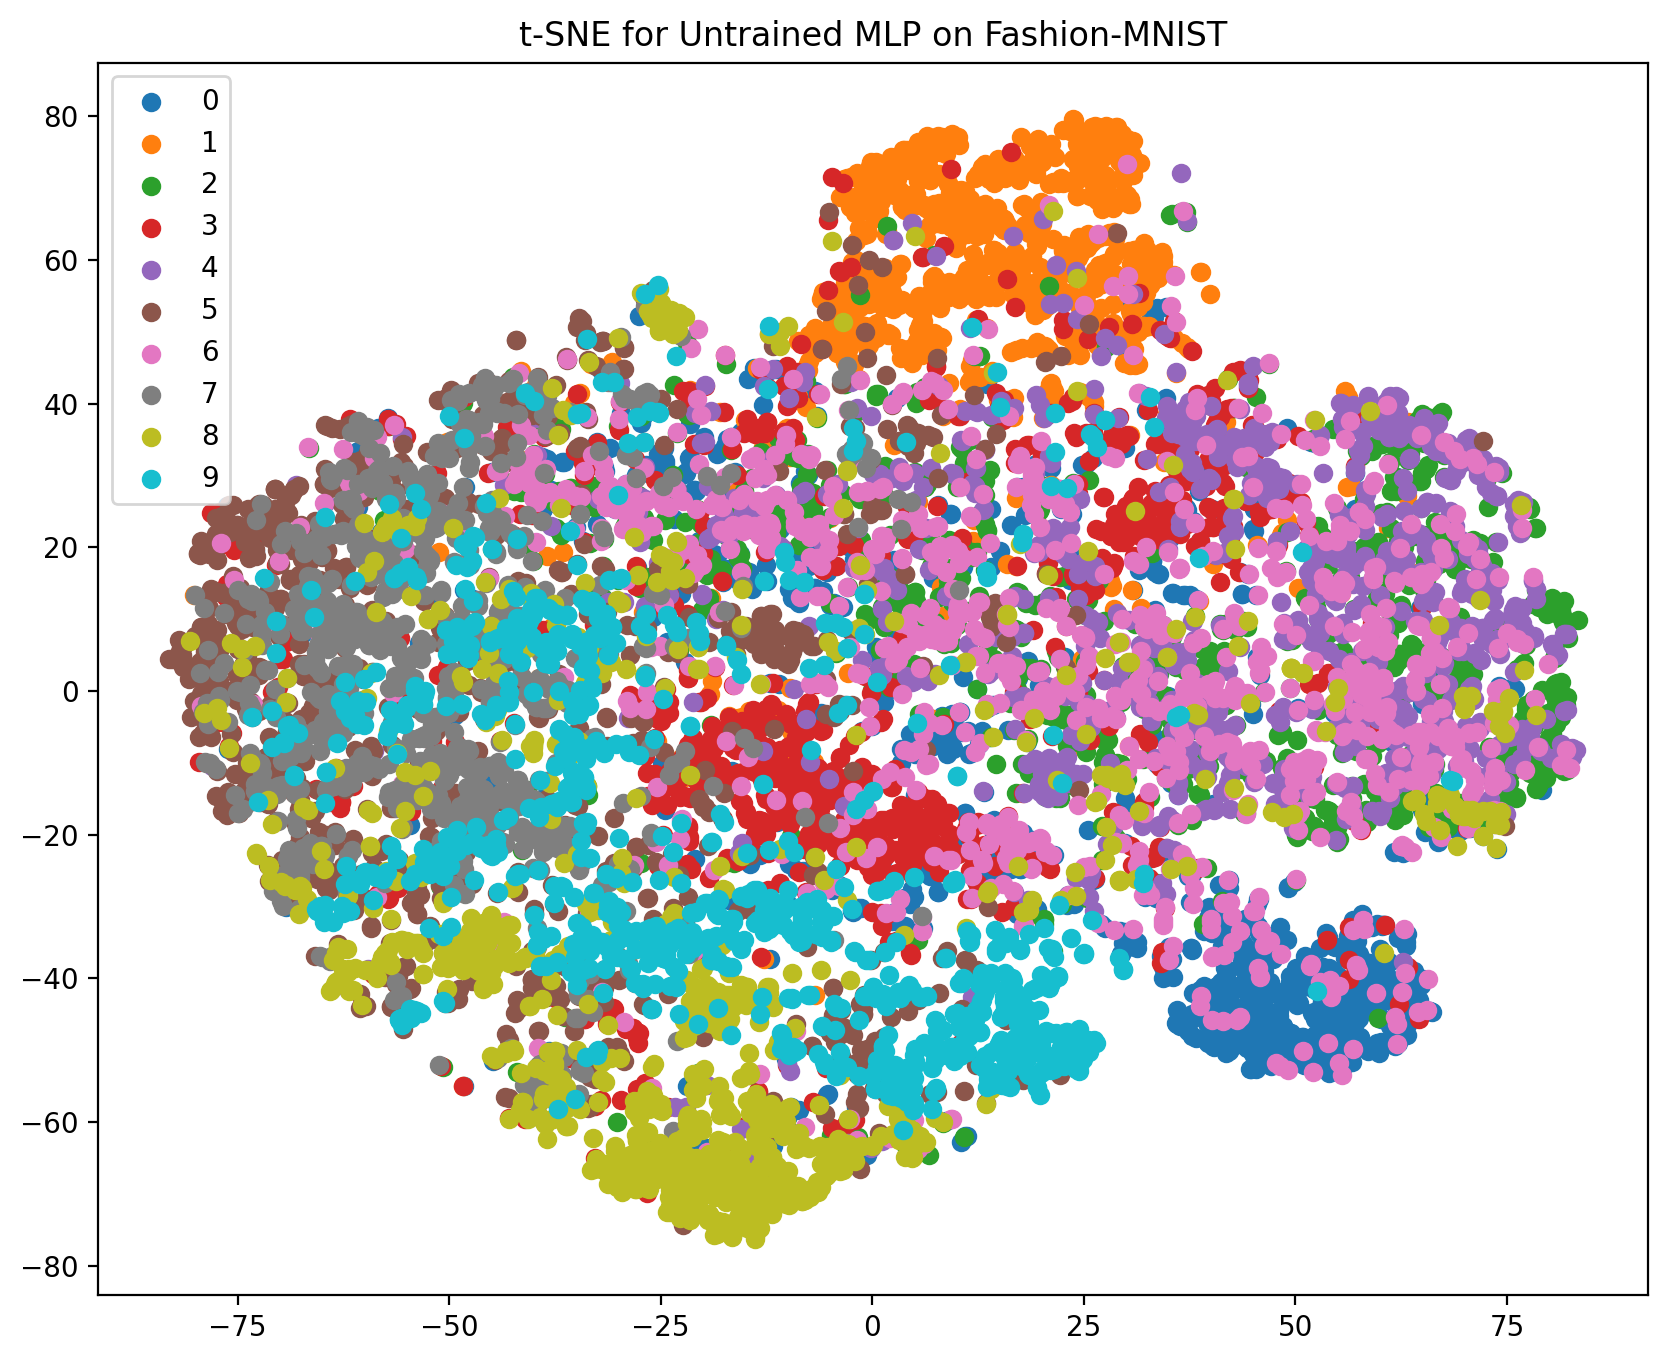

In [73]:
# Plot t-SNE for Fashion-MNIST
plot_tsne(untrained_predictions_fmnist, y_test_fmnist, "t-SNE for Untrained MLP on Fashion-MNIST")

##### *Trained MLP on FMNIST dataset*

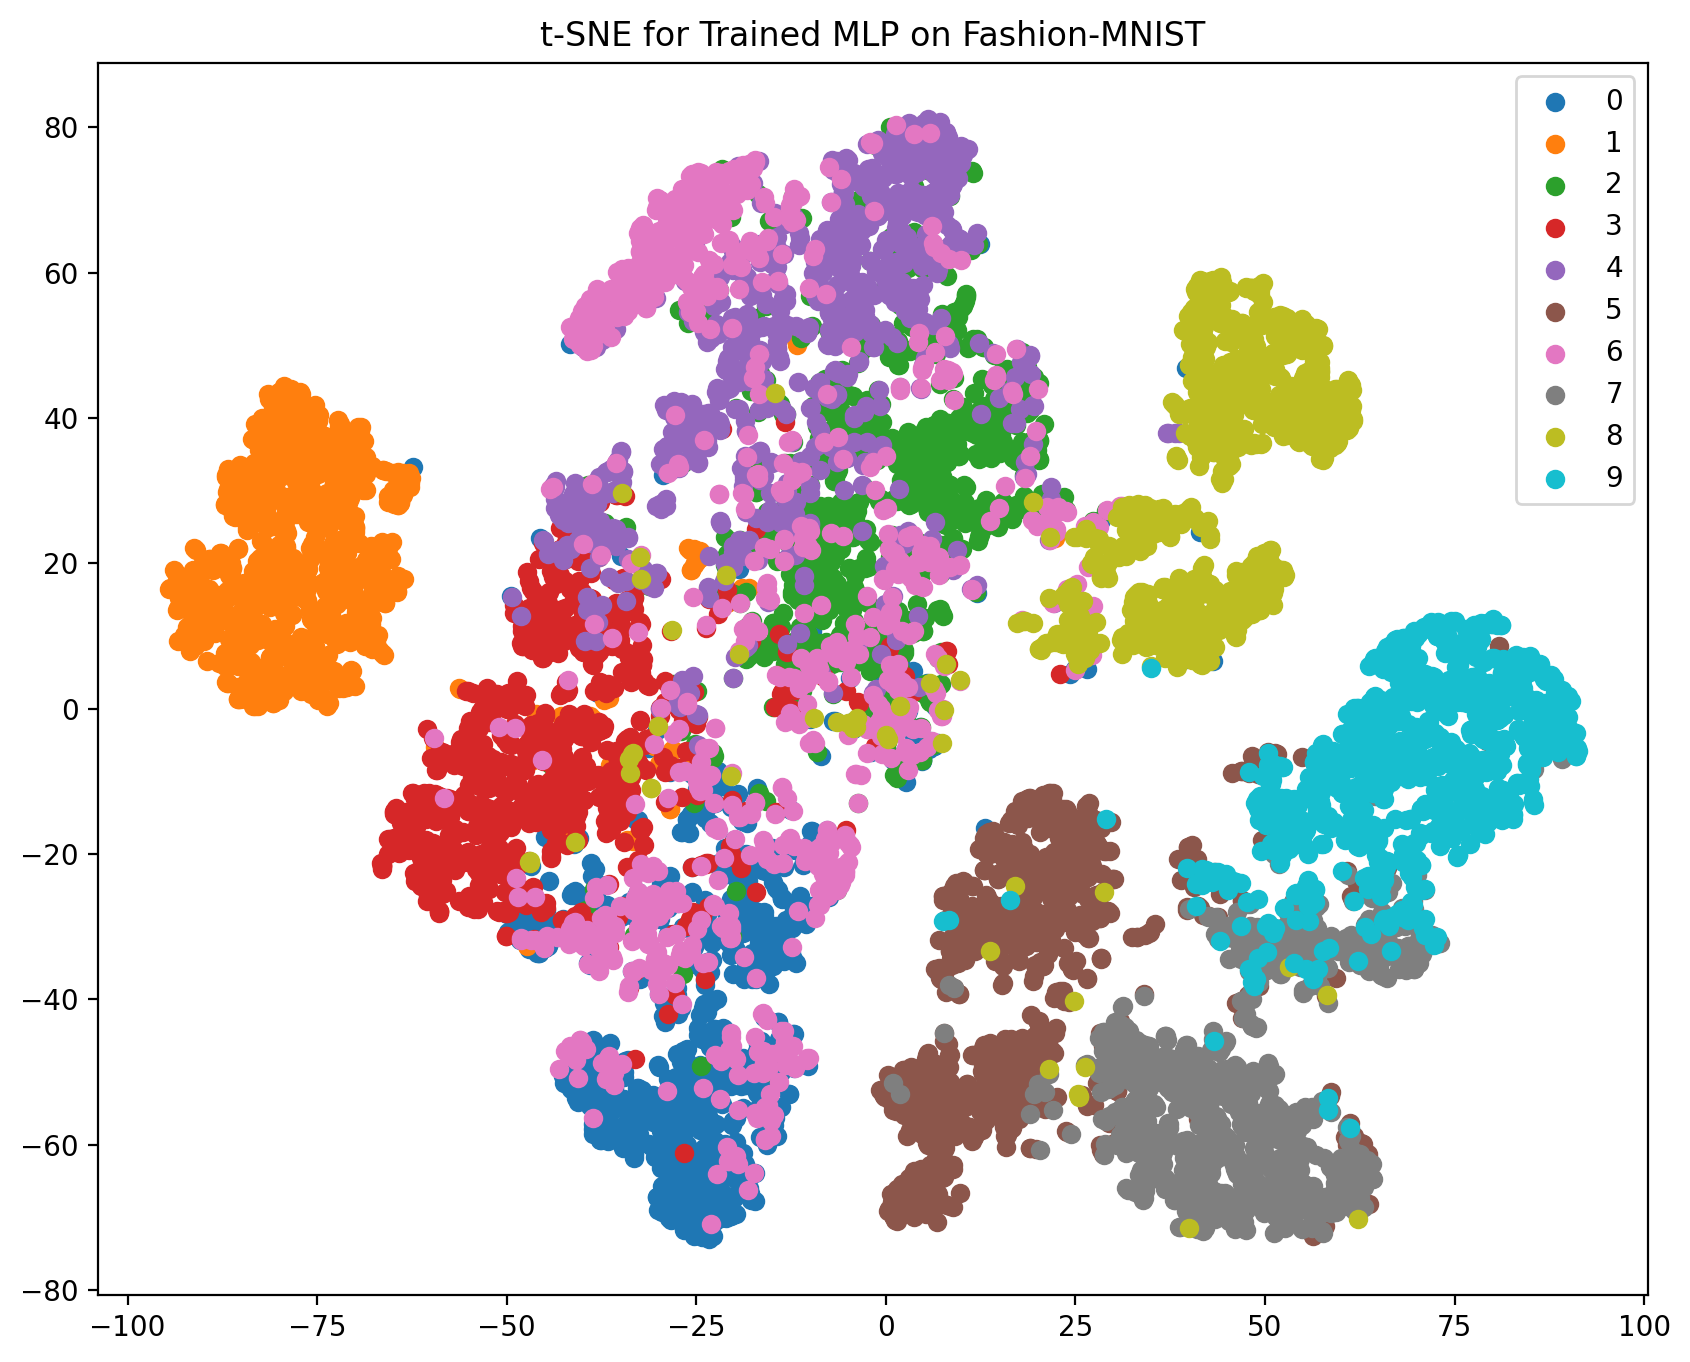

In [74]:
plot_tsne(trained_predictions_fmnist, y_test_fmnist, "t-SNE for Trained MLP on Fashion-MNIST")

### *Accuracy*

In [66]:
# Store the model's predictions on test data
y_pred_mnist = mnist_model.predict(x_test_mnist)
y_pred_fmnist_mnist = mnist_model.predict(x_test_fmnist)
y_pred_fmnist = fmnist_model.predict(x_test_fmnist)

accuracy_mnist = (np.argmax(y_pred_mnist, axis=1) == y_test_mnist).mean()
accuracy_fmnist_mnist = (np.argmax(y_pred_fmnist_mnist, axis=1) == y_test_fmnist).mean()
accuracy_fmnist = (np.argmax(y_pred_fmnist, axis=1) == y_test_fmnist).mean()

print(f"Accuracy of Trained MLP on MNIST:- {accuracy_mnist}")
print(f"Accuracy of Trained MLP on Fashion-MNIST using the MNIST model:- {accuracy_fmnist_mnist}")
print(f"Accuracy of Trained MLP on Fashion-MNIST:- {accuracy_fmnist}")

Accuracy of Trained MLP on MNIST:- 0.9646
Accuracy of Trained MLP on Fashion-MNIST using the MNIST model:- 0.0817
Accuracy of Trained MLP on Fashion-MNIST:- 0.8678
